# Resource-Efficient Waste Classification for Smart Recycling Systems

This project will implement an image-based waste classification system using transfer learning to support smart recycling applications.


In [1]:
!pip install -q kaggle


In [2]:
!wget https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip


--2026-01-11 15:52:49--  https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip [following]
--2026-01-11 15:52:49--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘dataset-resized.zip’

dataset-resized.zip 100%[===================>]  40.85M   160MB/s    in 0.3s    

2026-01-11 15:52:50 (160 MB/s) - ‘dataset-resized.zip’ saved [42834870/42834870]



This data set has 6 different groups - cardboard, metal, plastic, paper, glass and trash

In [3]:
!unzip dataset-resized.zip


Archive:  dataset-resized.zip
   creating: dataset-resized/
  inflating: dataset-resized/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/dataset-resized/
  inflating: __MACOSX/dataset-resized/._.DS_Store  
   creating: dataset-resized/cardboard/
  inflating: dataset-resized/cardboard/cardboard1.jpg  
  inflating: dataset-resized/cardboard/cardboard10.jpg  
  inflating: dataset-resized/cardboard/cardboard100.jpg  
  inflating: dataset-resized/cardboard/cardboard101.jpg  
  inflating: dataset-resized/cardboard/cardboard102.jpg  
  inflating: dataset-resized/cardboard/cardboard103.jpg  
  inflating: dataset-resized/cardboard/cardboard104.jpg  
  inflating: dataset-resized/cardboard/cardboard105.jpg  
  inflating: dataset-resized/cardboard/cardboard106.jpg  
  inflating: dataset-resized/cardboard/cardboard107.jpg  
  inflating: dataset-resized/cardboard/cardboard108.jpg  
  inflating: dataset-resized/cardboard/cardboard109.jpg  
  inflating: dataset-resized/cardboard/cardboard11.j

#Testing and Training
We use two diff folders to execute training on one, and testing on one for fair results - We also shuffle them to increase randomization and maintain fairness.

In [4]:
import os, shutil, random

base_dir = "dataset-resized"
train_dir = "dataset/train"
test_dir = "dataset/test"

classes = [d for d in os.listdir(base_dir)
           if os.path.isdir(os.path.join(base_dir, d))]

for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    images = os.listdir(cls_path)
    random.shuffle(images)

    split = int(0.8 * len(images))
    train_imgs = images[:split]
    test_imgs = images[split:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img),
                    os.path.join(train_dir, cls, img))

    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img),
                    os.path.join(test_dir, cls, img))


In [5]:
!ls dataset/train

cardboard  glass  metal  paper	plastic  trash


In [6]:
!ls dataset/test

cardboard  glass  metal  paper	plastic  trash


In [7]:
!mkdir -p dataset/test dataset/train

In [8]:
!ls


dataset  dataset-resized  dataset-resized.zip  __MACOSX  sample_data


Now we copy data in both the files, with and 80:20 ratio. Also, we use 224x224 as a standard size.

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [8]:
train_dataset = datasets.ImageFolder(
    root="dataset/train",
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root="dataset/test",
    transform=transform
)


In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)


In [10]:
class_names = train_dataset.classes
print(class_names)


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [11]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels[:5])


torch.Size([32, 3, 224, 224])
tensor([3, 0, 0, 4, 1])


#ResNet

In [12]:
import torchvision.models as models
import torch.nn as nn
resnet = models.resnet18(pretrained=True)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


In [13]:
for param in resnet.parameters():
    param.requires_grad = False


In [14]:
num_classes = len(class_names)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)


now i will do the optimizer for errors

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)


In [17]:
epochs = 5

for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Loss: {running_loss/len(train_loader):.4f} "
          f"Train Acc: {train_acc:.2f}%")


Epoch [1/5] Loss: 1.3041 Train Acc: 50.02%
Epoch [2/5] Loss: 0.8407 Train Acc: 72.76%
Epoch [3/5] Loss: 0.7066 Train Acc: 77.02%
Epoch [4/5] Loss: 0.6406 Train Acc: 78.80%
Epoch [5/5] Loss: 0.6030 Train Acc: 79.40%


In [18]:
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 80.71%


#Error Analysis
Confusion matrices are used to analyze class performance and common failures.


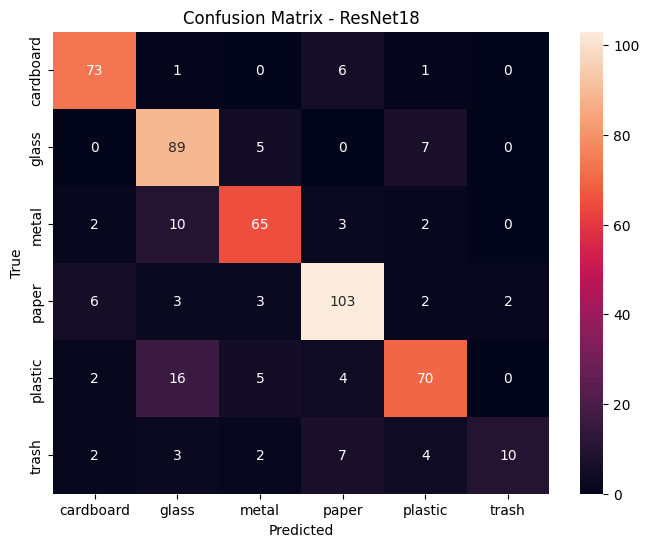

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet18")
plt.show()


#MobileNet
Now we implement MobileNet

In [21]:
mobilenet = models.mobilenet_v2(pretrained=True)

for param in mobilenet.parameters():
    param.requires_grad = False

mobilenet.classifier[1] = nn.Linear(
    mobilenet.classifier[1].in_features,
    len(class_names)
)

mobilenet = mobilenet.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 165MB/s]


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)


In [23]:
epochs = 5

for epoch in range(epochs):
    mobilenet.train()
    correct = 0
    total = 0
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.4f} | Acc: {acc:.2f}%")


Epoch 1 | Loss: 1.1507 | Acc: 59.09%
Epoch 2 | Loss: 0.7084 | Acc: 76.92%
Epoch 3 | Loss: 0.5851 | Acc: 81.67%
Epoch 4 | Loss: 0.5187 | Acc: 83.41%
Epoch 5 | Loss: 0.4995 | Acc: 84.15%


It is successfull, Loss decreases and Accuracy increases.

#Comparison between MobileNet and ResNet

In [24]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print("ResNet params:", count_params(resnet))
print("MobileNet params:", count_params(mobilenet))


ResNet params: 11179590
MobileNet params: 2231558


In [31]:
def measure_time(model, loader, runs=20):
    model.eval()
    images, _ = next(iter(loader))
    images = images.to(device)

    # Warm-up
    with torch.no_grad():
        for _ in range(5):
            model(images)

    start = time.time()

    with torch.no_grad():
        for _ in range(runs):
            model(images)

    end = time.time()

    return (end - start) * 1000 / runs


In [33]:
import time


In [34]:
print("ResNet inference (ms):", measure_time(resnet, test_loader))
print("MobileNet inference (ms):", measure_time(mobilenet, test_loader))


ResNet inference (ms): 2921.763837337494
MobileNet inference (ms): 2241.72066450119


In [35]:
import torchvision.transforms.functional as F
import random

def add_noise(img):
    noise = torch.randn_like(img) * 0.1
    return torch.clamp(img + noise, 0, 1)

noisy_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(add_noise)
])

noisy_test = datasets.ImageFolder(
    root="dataset/test",
    transform=noisy_transform
)

noisy_loader = DataLoader(noisy_test, batch_size=32)


In [36]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

print("ResNet noisy acc:", evaluate(resnet, noisy_loader))
print("MobileNet noisy acc:", evaluate(mobilenet, noisy_loader))


ResNet noisy acc: 48.031496062992126
MobileNet noisy acc: 47.83464566929134


Save The Models:

In [37]:
torch.save(resnet.state_dict(), "resnet18_waste.pth")
torch.save(mobilenet.state_dict(), "mobilenet_waste.pth")


In [45]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn

# class names (must match training)
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# load model
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load("resnet18_waste.pth"))
model = model.to(device)
model.eval()

# load image
img = Image.open("basket.jpg").convert("RGB")

# preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

img_tensor = transform(img).unsqueeze(0).to(device)

# inference
with torch.no_grad():
    output = model(img_tensor)
    pred = torch.argmax(output, 1)

print("Prediction:", class_names[pred.item()])


Prediction: cardboard
